# 배우 이미지를 애니메이션화
- file requirments
    - ``shape_predictor_68_face_landmarks.dat``
    - ``shape_predictor_68_face_landmarks.dat.bz2``

## 1. 패키지 로드

In [2]:
import torch 
from PIL import Image

import os
import dlib
import collections
from typing import Union, List
import numpy as np
import matplotlib.pyplot as plt

import PIL.Image
import PIL.ImageFile
import scipy.ndimage
import warnings
warnings.filterwarnings('ignore')

## 2. 모델 로드

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = torch.hub.load("bryandlee/animegan2-pytorch:main", "generator", device=device).eval()
face2paint = torch.hub.load("bryandlee/animegan2-pytorch:main", "face2paint", device=device, side_by_side=True)

Using cache found in /home/lab22/.cache/torch/hub/bryandlee_animegan2-pytorch_main
Using cache found in /home/lab22/.cache/torch/hub/bryandlee_animegan2-pytorch_main


## 3. 함수 정의

In [10]:
def get_dlib_face_detector(predictor_path: str = "shape_predictor_68_face_landmarks.dat"):
    if not os.path.isfile(predictor_path):
        model_file = "shape_predictor_68_face_landmarks.dat.bz2"
        os.system(f"wget http://dlib.net/files/{model_file}")
        os.system(f"bzip2 -dk {model_file}")

    detector = dlib.get_frontal_face_detector()
    shape_predictor = dlib.shape_predictor(predictor_path)

    def detect_face_landmarks(img: Union[Image.Image, np.ndarray]):
        if isinstance(img, Image.Image):
            img = np.array(img)
        faces = []
        dets = detector(img)
        for d in dets:
            shape = shape_predictor(img, d)
            faces.append(np.array([[v.x, v.y] for v in shape.parts()]))
        return faces
    
    return detect_face_landmarks

In [11]:
def display_facial_landmarks(
    img: Image, 
    landmarks: List[np.ndarray],
    fig_size=[15, 15]
):
    plot_style = dict(
        marker='o',
        markersize=4,
        linestyle='-',
        lw=2
    )
    pred_type = collections.namedtuple('prediction_type', ['slice', 'color'])
    pred_types = {
        'face': pred_type(slice(0, 17), (0.682, 0.780, 0.909, 0.5)),
        'eyebrow1': pred_type(slice(17, 22), (1.0, 0.498, 0.055, 0.4)),
        'eyebrow2': pred_type(slice(22, 27), (1.0, 0.498, 0.055, 0.4)),
        'nose': pred_type(slice(27, 31), (0.345, 0.239, 0.443, 0.4)),
        'nostril': pred_type(slice(31, 36), (0.345, 0.239, 0.443, 0.4)),
        'eye1': pred_type(slice(36, 42), (0.596, 0.875, 0.541, 0.3)),
        'eye2': pred_type(slice(42, 48), (0.596, 0.875, 0.541, 0.3)),
        'lips': pred_type(slice(48, 60), (0.596, 0.875, 0.541, 0.3)),
        'teeth': pred_type(slice(60, 68), (0.596, 0.875, 0.541, 0.4))
    }

    fig = plt.figure(figsize=fig_size)
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(img)
    ax.axis('off')

    for face in landmarks:
        for pred_type in pred_types.values():
            ax.plot(
                face[pred_type.slice, 0],
                face[pred_type.slice, 1],
                color=pred_type.color, **plot_style
            )
    plt.show()

In [12]:
def align_and_crop_face(
    img: Image.Image,
    landmarks: np.ndarray,
    expand: float = 1.0,
    output_size: int = 1024, 
    transform_size: int = 4096,
    enable_padding: bool = True,
):
    # Parse landmarks.
    # pylint: disable=unused-variable
    lm = landmarks
    lm_chin          = lm[0  : 17]  # left-right
    lm_eyebrow_left  = lm[17 : 22]  # left-right
    lm_eyebrow_right = lm[22 : 27]  # left-right
    lm_nose          = lm[27 : 31]  # top-down
    lm_nostrils      = lm[31 : 36]  # top-down
    lm_eye_left      = lm[36 : 42]  # left-clockwise
    lm_eye_right     = lm[42 : 48]  # left-clockwise
    lm_mouth_outer   = lm[48 : 60]  # left-clockwise
    lm_mouth_inner   = lm[60 : 68]  # left-clockwise

    # Calculate auxiliary vectors.
    eye_left     = np.mean(lm_eye_left, axis=0)
    eye_right    = np.mean(lm_eye_right, axis=0)
    eye_avg      = (eye_left + eye_right) * 0.5
    eye_to_eye   = eye_right - eye_left
    mouth_left   = lm_mouth_outer[0]
    mouth_right  = lm_mouth_outer[6]
    mouth_avg    = (mouth_left + mouth_right) * 0.5
    eye_to_mouth = mouth_avg - eye_avg

    # Choose oriented crop rectangle.
    x = eye_to_eye - np.flipud(eye_to_mouth) * [-1, 1]
    x /= np.hypot(*x)
    x *= max(np.hypot(*eye_to_eye) * 2.0, np.hypot(*eye_to_mouth) * 1.8)
    x *= expand
    y = np.flipud(x) * [-1, 1]
    c = eye_avg + eye_to_mouth * 0.1
    quad = np.stack([c - x - y, c - x + y, c + x + y, c + x - y])
    qsize = np.hypot(*x) * 2

    # Shrink.
    shrink = int(np.floor(qsize / output_size * 0.5))
    if shrink > 1:
        rsize = (int(np.rint(float(img.size[0]) / shrink)), int(np.rint(float(img.size[1]) / shrink)))
        img = img.resize(rsize, PIL.Image.ANTIALIAS)
        quad /= shrink
        qsize /= shrink

    # Crop.
    border = max(int(np.rint(qsize * 0.1)), 3)
    crop = (int(np.floor(min(quad[:,0]))), int(np.floor(min(quad[:,1]))), int(np.ceil(max(quad[:,0]))), int(np.ceil(max(quad[:,1]))))
    crop = (max(crop[0] - border, 0), max(crop[1] - border, 0), min(crop[2] + border, img.size[0]), min(crop[3] + border, img.size[1]))
    if crop[2] - crop[0] < img.size[0] or crop[3] - crop[1] < img.size[1]:
        img = img.crop(crop)
        quad -= crop[0:2]

    # Pad.
    pad = (int(np.floor(min(quad[:,0]))), int(np.floor(min(quad[:,1]))), int(np.ceil(max(quad[:,0]))), int(np.ceil(max(quad[:,1]))))
    pad = (max(-pad[0] + border, 0), max(-pad[1] + border, 0), max(pad[2] - img.size[0] + border, 0), max(pad[3] - img.size[1] + border, 0))
    if enable_padding and max(pad) > border - 4:
        pad = np.maximum(pad, int(np.rint(qsize * 0.3)))
        img = np.pad(np.float32(img), ((pad[1], pad[3]), (pad[0], pad[2]), (0, 0)), 'reflect')
        h, w, _ = img.shape
        y, x, _ = np.ogrid[:h, :w, :1]
        mask = np.maximum(1.0 - np.minimum(np.float32(x) / pad[0], np.float32(w-1-x) / pad[2]), 1.0 - np.minimum(np.float32(y) / pad[1], np.float32(h-1-y) / pad[3]))
        blur = qsize * 0.02
        img += (scipy.ndimage.gaussian_filter(img, [blur, blur, 0]) - img) * np.clip(mask * 3.0 + 1.0, 0.0, 1.0)
        img += (np.median(img, axis=(0,1)) - img) * np.clip(mask, 0.0, 1.0)
        img = PIL.Image.fromarray(np.uint8(np.clip(np.rint(img), 0, 255)), 'RGB')
        quad += pad[:2]

    # Transform.
    img = img.transform((transform_size, transform_size), PIL.Image.QUAD, (quad + 0.5).flatten(), PIL.Image.BILINEAR)
    if output_size < transform_size:
        img = img.resize((output_size, output_size), PIL.Image.ANTIALIAS)

    return img

## 4. TEST

### 1) 이미지 로드

In [13]:
img = Image.open('../image_data/Actor/감우성.jpg').convert("RGB")

### 2) face detecting

In [14]:
face_detector = get_dlib_face_detector()
landmarks = face_detector(img)

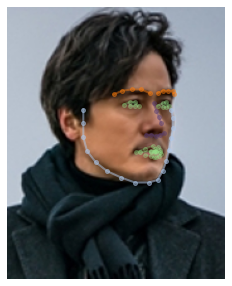

In [16]:
display_facial_landmarks(img, landmarks, fig_size=[5, 5])

### 3) convert real to anime

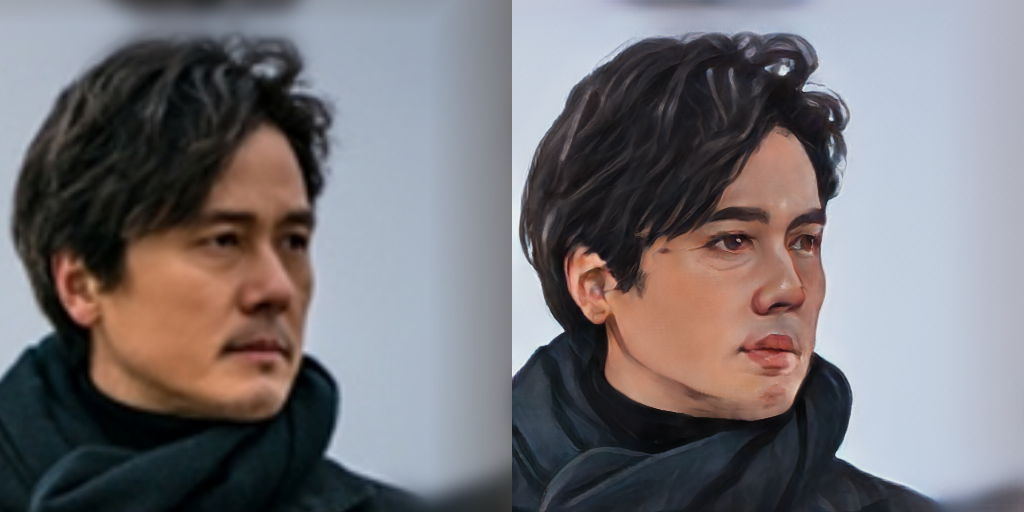

In [15]:
for landmark in landmarks:
    face = align_and_crop_face(img, landmark, expand=1.3)
    display(face2paint(model=model, img=face, size=512))

### 4) 변환된 이미지만 crop하여 저장

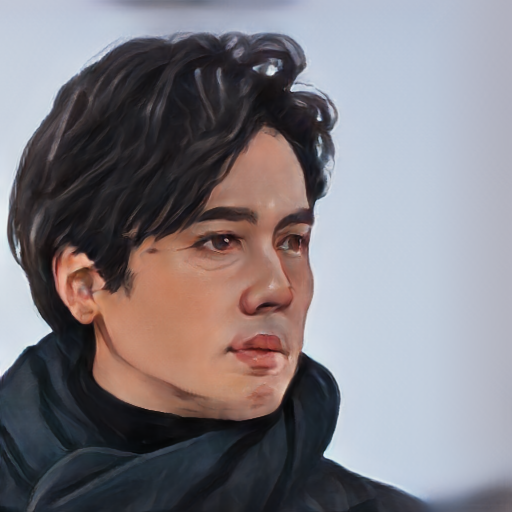

In [18]:
# 변환이미지 확인
face2paint(model=model, img=face, size=512).crop((512, 0, 1024, 512))

In [17]:
# 변환이미지 저장
face2paint(model=model, img=face, size=512).crop((512, 0, 1024, 512)).save('test.jpg', 'JPEG') # 저장

## 4. for 문으로 모든 배우 사진을 만화화

### 1) 배우 데이터 로드

In [19]:
import pandas as pd
from tqdm.notebook import tqdm

In [22]:
actor_df = pd.read_csv('../text_data/Actor.csv', encoding='utf-8-sig')
actor_df.head(2)

,Name,Age,Sex,수상내역,드라마활동,activation_content,사진url,배역내용,"제목, 내용"
0,감우성,52,남,"['2018 SBS 연기대상 대상', '2018 SBS 연기대상 베스트 커플상', ...",['바람이 분다/주연/권도훈 역/https://search.naver.com/sea...,"MBC 20기 공채 탤런트로 배우 생활을 시작했으며 동기로 한석규, 박철, 차광수,...",https://search.pstatic.net/common?type=b&size=...,['첫사랑 수진과 열렬한 연애 끝에 결혼까지 성공했다. 남에게 피해 주지 않고 올곧...,"감우성 닮으면 잘생긴거냐?,내 친구 미용실가서 누나가 감우성 닮았다는데 잘생긴거냐 ..."
1,강경준,39,남,"['2017 MBC 연기대상 연속극부문 남자 우수연기상', '2004 MBC 방송연...",['별별 며느리/주연/최한주 역/https://search.naver.com/sea...,"초등학교 시절에는 야구, 중학교 시절에는 농구선수였었다. 농구를 소재로 한 드라마 ...",https://search.pstatic.net/common?type=b&size=...,"['흙수저? 아니, 몸짱 얼짱 마음까지 짱인 태권도장 사범. 얼굴만 봐도 신뢰감이 ...","강경준 -> 강 산 -> 강승호네,이름 두번이나 바꿨구나\n그러고보니 남다 딱 장신..."


### 2) 배우 이름 리스트화

In [23]:
# 배우의 이름 list
actor_name_list = actor_df.Name.to_list()

### 3) 배우의 사진을 모두 만화화

In [24]:
# 배우 이름 list에 있는 배우의 사진을 모두 만화화하여 저장
for name in tqdm(actor_name_list):
    img = Image.open(f'../image_data/Actor/{name}.jpg').convert("RGB")

    face_detector = get_dlib_face_detector()
    landmarks = face_detector(img)

    for landmark in landmarks:
        face = align_and_crop_face(img, landmark, expand=1.3)
        #display(face2paint(model=model, img=face, size=512))
    
    face2paint(model=model, img=face, size=512).crop((512, 0, 1024, 512)).save(f'../image_data/Actor2Webtoon/webtoon_{name}.jpg', 'JPEG')

  0%|          | 0/252 [00:00<?, ?it/s]